In [1]:
import math as math
import numpy as np
import random as rd
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
from matplotlib.pyplot import imshow as imageplot

#pour des animations
from IPython.display import clear_output
import time

import scipy as scp
import pylab as pyl
from matplotlib import cm
import scipy.io as sio
from mpl_toolkits.mplot3d import Axes3D
import warnings

warnings.filterwarnings('ignore')
%matplotlib inline
%load_ext autoreload
%autoreload 2
from scipy.ndimage import distance_transform_edt as distance

from skimage.color import rgb2gray
from skimage import img_as_float
from skimage.segmentation import chan_vese
from skimage import data
from skimage.filters import gaussian
from skimage.segmentation import active_contour

# I) Chargement de 4 images tests

### Modification d'image

In [3]:
#ajout de bruit
def bruit(image, m, sigma):
    sx, sy = np.shape(image)
    return image + np.random.normal(m, np.sqrt(sigma), (sx, sy))

In [2]:
#conversion en format (sx,sy)
def transforme(image):
    """
    Renvoie l'image (3, sx, sy) en image (sx, sy)
    """
    return np.array([[image[x][y][0] for y in range(len(image[0]))] for x in range(len(image))])

In [3]:
#l'imgae dans [0,1]
def image01(image):
    """
    Renvoies l'image avec des valeurs entre 0 et 1.
    
    image : (sx, sy)
    """
    image = image - np.min(image)
    if np.max(image) != 0:
        image = image / np.max(image)
    return image

### Les images

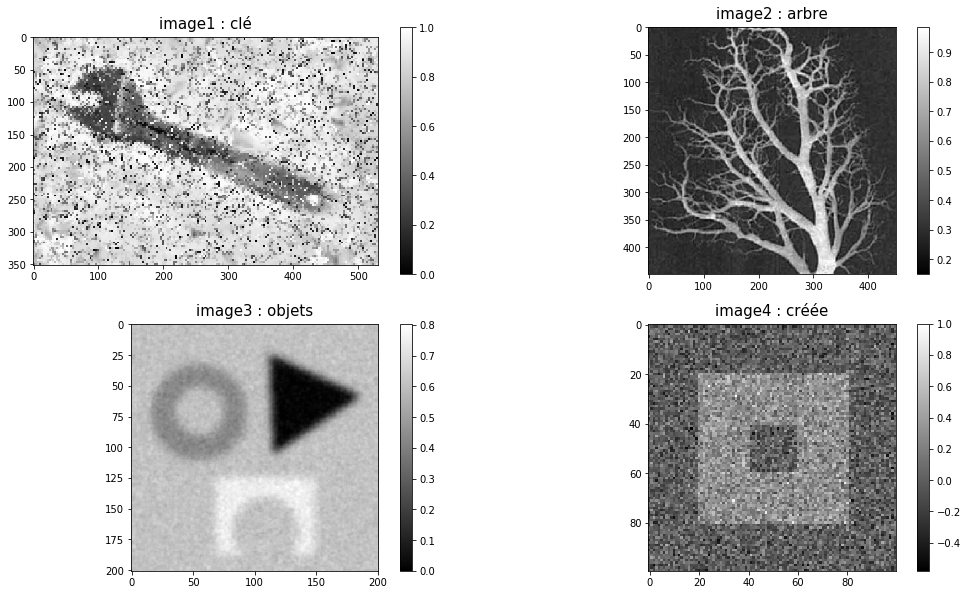

In [6]:
image1 = transforme(mpimg.imread("test1.png"))
image2 = mpimg.imread("test2.png")
image3 = mpimg.imread("test3.png")

# image créée
image4 = np.zeros((100, 100))
for x in range(20, 81):
    image4[20:41, x], image4[60:81, x] = 1., 1.
for y in range(20, 81):
    image4[y, 20:41], image4[y, 60:81] = 1., 1.
image4 = bruit(image4, 0, 0.3)
image4 = image4 / np.max(np.abs(image4))


plt.figure(figsize = (17,10))
plt.subplot(221)
plt.title('image1 : clé', y = 1.01, fontsize = 15)
plt.imshow(image1, cmap = 'gray')
plt.colorbar()
plt.subplot(222)
plt.title('image2 : arbre', y = 1.01, fontsize = 15)
plt.imshow(image2, cmap = 'gray')
plt.colorbar()
plt.subplot(223)
plt.title('image3 : objets', y = 1.01, fontsize = 15)
plt.imshow(image3, cmap = 'gray')
plt.colorbar()
plt.subplot(224)
plt.title('image4 : créée', y = 1.01, fontsize = 15)
plt.imshow(image4, cmap = 'gray')
plt.colorbar()
plt.show()

# II) Fonctions utiles

In [7]:
def heavyside(x, eps):
    return 0.5 * (1. + (2. / np.pi) * np.arctan(x / eps))

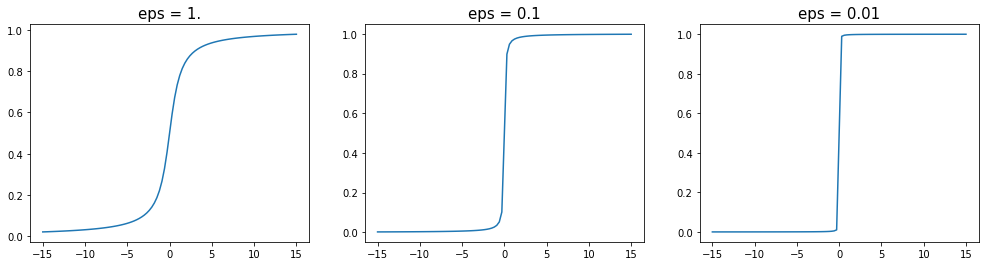

In [8]:
x = np.linspace(-15, 15, 101)

plt.figure(figsize = (17, 4))
plt.subplot(131)
plt.title('eps = 1.', fontsize = 15)
plt.plot(x, heavyside(x, 1.))
plt.subplot(132)
plt.title('eps = 0.1', fontsize = 15)
plt.plot(x, heavyside(x, 0.1))
plt.subplot(133)
plt.title('eps = 0.01', fontsize = 15)
plt.plot(x, heavyside(x, 0.01))
plt.show()

In [9]:
def delta(x, eps):
    return eps / (eps ** 2 + x ** 2)

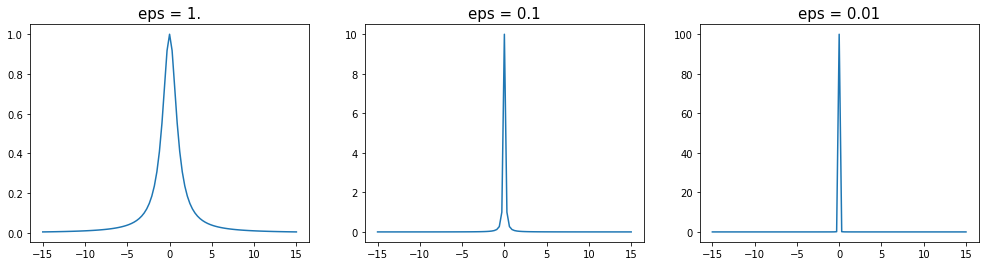

In [10]:
x = np.linspace(-15, 15, 101)

plt.figure(figsize = (17, 4))
plt.subplot(131)
plt.title('eps = 1.', fontsize = 15)
plt.plot(x, delta(x, 1.))
plt.subplot(132)
plt.title('eps = 0.1', fontsize = 15)
plt.plot(x, delta(x, 0.1))
plt.subplot(133)
plt.title('eps = 0.01', fontsize = 15)
plt.plot(x, delta(x, 0.01))
plt.show()

# III) Initialisation du level set

Le level-set démarre en définissant une fonction $f:\mathbb{R}^2\rightarrow\mathbb{R}$ qui possède au moins une valeur positive et une négative sur l'ensemble $\Omega$.

In [11]:
def f1(x, y, sx, sy):  #on peut modifier s
    """fonction de chan-vese"""
    s = 5.
    return np.sin(np.pi / s * x) * np.sin(np.pi / s * y)

def f2(x, y, sx, sy):
    """autre fonction test"""
    return np.cos(x) * np.sin(x) * np.cos(y) * np.sin(y)

def f3(x, y, sx, sy, s = 0.):  # on peut choisir le rayon en changeant 0<s<1 #ici <0.989
    """fonction cercle au milieu"""
    m = np.sqrt(((sx - 1) / 2) ** 2 + ((sy - 1) / 2) ** 2)  # le minimum de la fonction se trouve au 4 coins, ici (0,0)
    s = 0.9
    if s <= 0 or s >= 0:
        s = 0.5
    return m - s * m - np.sqrt(((sx - 1) / 2 - x) ** 2 + ((sy - 1) / 2 - y) ** 2)


def level_set(sx, sy, f):
    """renvoie une image avec f appliqué en chaque pixel"""
    phi = np.zeros((sx, sy))
    for x in range(sx):
        for y in range(sy):
            phi[x, y] = f(x, y, sx, sy)
    return phi

L'image $\phi = f(\Omega)$ est l'initialisation pour le level-set, on représente ceux que l'ont a défini à gauche, et a droite on les a segmentent en noir et blanc puis on a ajouté le contour.

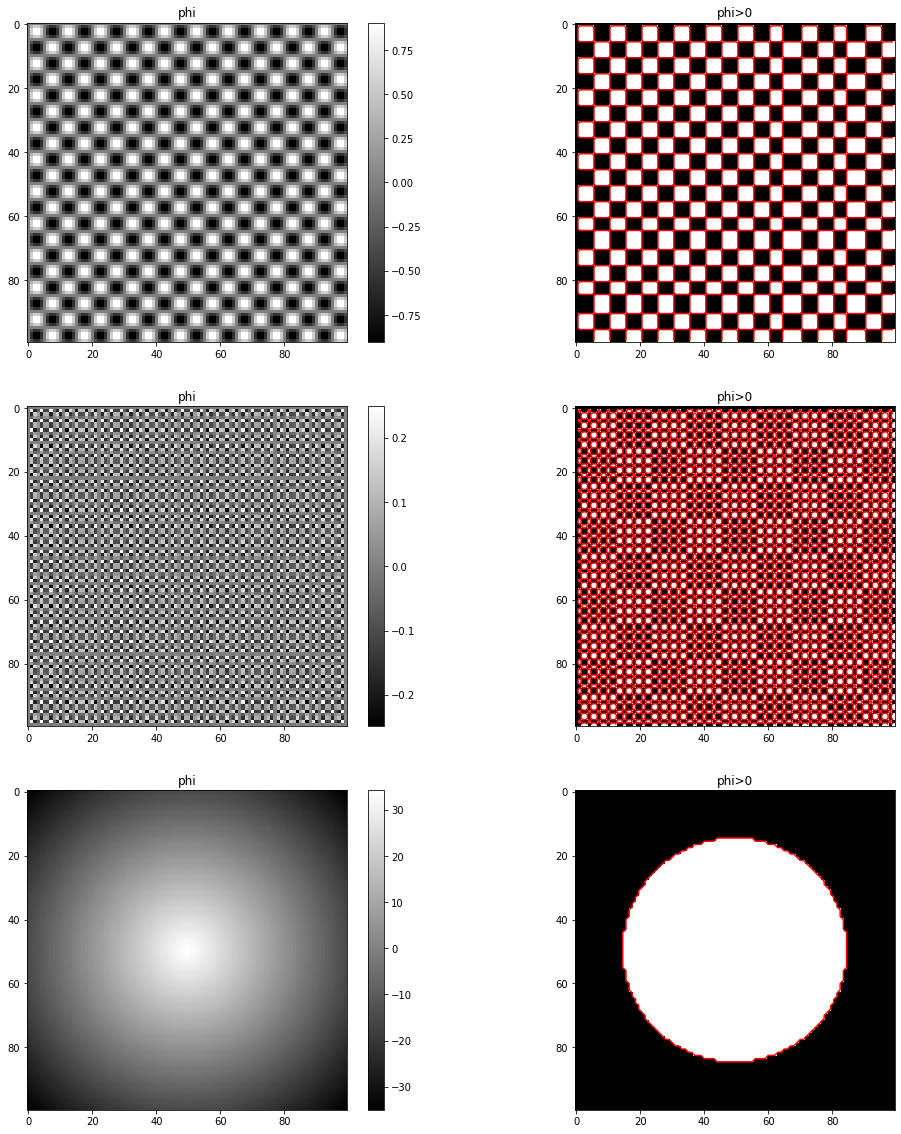

In [12]:
sx, sy = image4.shape
phi = level_set(sx, sy, f1)
segmentation = np.float_(phi > 0)

plt.figure(figsize = (17, 20))
plt.subplot(321)
plt.title('phi')
plt.imshow(phi, cmap = 'gray')
plt.colorbar()

plt.subplot(322)
plt.title('phi>0')
plt.imshow(segmentation, cmap = 'gray')
plt.contour(segmentation, 1, colors = ['None', 'red'])

phi = level_set(sx, sy, f2)
segmentation = np.float_(phi > 0)

plt.subplot(323)
plt.title('phi')
plt.imshow(phi, cmap = 'gray')
plt.colorbar()

plt.subplot(324)
plt.title('phi>0')
plt.imshow(segmentation, cmap = 'gray')
plt.contour(segmentation, 1, colors = ['None', 'red'])

phi = level_set(sx, sy, f3)
segmentation = np.float_(phi > 0)

plt.subplot(325)
plt.title('phi')
plt.imshow(phi, cmap = 'gray')
plt.colorbar()

plt.subplot(326)
plt.title('phi>0')
plt.imshow(segmentation, cmap = 'gray')
plt.contour(segmentation, 1, colors = ['None', 'red'])
plt.show()

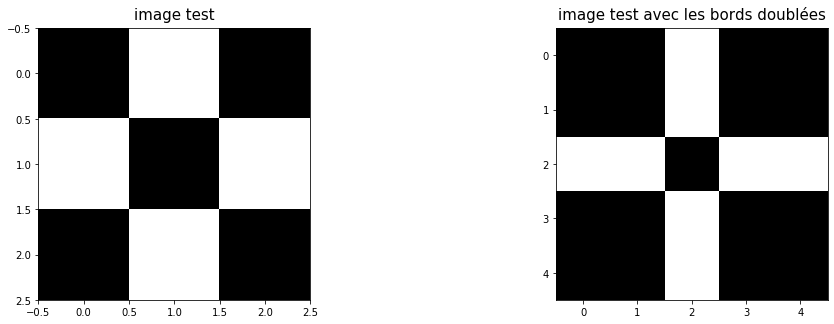

(3, 3)
(5, 5)


In [13]:
def double_bord(image, sx, sy):
    phi = np.zeros((sx + 2, sy + 2))
    phi[1:-1, 1:-1] = image #milieu
    phi[0,1:-1] = image[0,:] #haut
    phi[-1,1:-1] = image[-1,:] #bas
    phi[1:-1,0] = image[:,0] #gauche
    phi[1:-1,-1] = image[:,-1] #droite
    phi[0,0] = image[0,0] #angle haut gauche
    phi[0,-1] = image[0,-1] #angle haut droit
    phi[-1,0] = image[-1,0] #angle bas gauche
    phi[-1,-1] = image[-1,-1] #angle bas droite
    return phi

test = np.zeros((3, 3))
test[0, 1], test[1, 0], test[1, 2], test[2, 1] = 1., 1., 1., 1.
btest = double_bord(test, test.shape[0], test.shape[1])

plt.figure(figsize = (17,5))
plt.subplot(121)
plt.title('image test', y = 1.01, fontsize = 15)
plt.imshow(test, cmap = 'gray')
plt.subplot(122)
plt.title('image test avec les bords doublées', y = 1.01, fontsize = 15)
plt.imshow(btest, cmap = 'gray')
plt.show()
print(test.shape)
print(btest.shape)

In [14]:
def calcul_c1_c2(image, H1, H2, eps):
    # Calcul de c1
    den = np.sum(H1)  # dénominateur pour c1
    num = np.sum(image * H1)  # numérateur pour c1
    if den != 0:
        c1 = num / den
    # Calcul de c2
    H2 = 1 - H1
    den = np.sum(H2)
    num = np.sum(image * H2)
    if den != 0:
        c2 = num / den
    return c1, c2

In [17]:
def energie(image, sx, sy, phi, mu, lambda1, lambda2, eps, eta = 1e-8):
    """Energie"""
    H1 = heavyside(phi, eps)  # =H(phi)
    H2 = 1 - H1
    c1, c2 = calcul_c1_c2(image, H1, H2, eps)
    #print(c1, c2)
    # AIRES
    aire = lambda1 * (image - c1) ** 2 * H1 + lambda2 * (image - c2) ** 2 * H2
    
    # PÉRIMÈTRE
    phi2 = double_bord(phi, sx, sy)  #on double les bords de l'image phi
    fy = (phi2[2:, 1:-1] - phi2[:-2, 1:-1]) / 2.0
    fx = (phi2[1:-1, 2:] - phi2[1:-1, :-2]) / 2.0
    fyy = phi2[2:, 1:-1] + phi2[:-2, 1:-1] - 2 * phi
    fxx = phi2[1:-1, 2:] + phi2[1:-1, :-2] - 2 * phi
    fxy = .25 * (phi2[2:, 2:] + phi2[:-2, :-2] - phi2[:-2, 2:] - phi2[2:, :-2])
    grad2 = fx ** 2 + fy ** 2
    perim = mu * ((fxx * fy ** 2 - 2 * fxy * fx * fy + fyy * fx ** 2) / (grad2 * np.sqrt(grad2) + eta))

    return np.sum(aire) + np.sum(perim)

print(energie(image4, sx, sy, phi, 0.25, 1, 1, 1, eta = 1e-8))

360.63172827608145


In [28]:
def chanvese(image, f, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2):
    """
    Algorithme de Chan-Vese
    
    image : (sx, sy) avec valeur entre 0 et 1
    
    f : fonction pour le level set
    """
    sx, sy = image.shape

    # Initialisation du level set
    phi = level_set(sx, sy, f)

    Energie = [energie(image, sx, sy, phi, mu, lambda1, lambda2, eps, eta2)]
    segmentation = phi > 0  # on peut mettre np.int_ pour des 1 et 0

    CV = tol + 1
    it = 0  # itération
    while (it < max_it and CV > tol):

        phi_tmp = phi

        phi2 = double_bord(phi, sx, sy)
        phixp = phi2[1:-1, 2:] - phi2[1:-1, 1:-1]
        phixn = phi2[1:-1, 1:-1] - phi2[1:-1, :-2]
        phix0 = (phi2[1:-1, 2:] - phi2[1:-1, :-2]) / 2.
        phiyp = phi2[2:, 1:-1] - phi2[1:-1, 1:-1]
        phiyn = phi2[1:-1, 1:-1] - phi2[:-2, 1:-1]
        phiy0 = (phi2[2:, 1:-1] - phi2[:-2, 1:-1]) / 2.
        C1 = 1. / np.sqrt(eta2 + phixp ** 2 + phiy0 ** 2)
        C2 = 1. / np.sqrt(eta2 + phixn ** 2 + phiy0 ** 2)
        C3 = 1. / np.sqrt(eta2 + phix0 ** 2 + phiyp ** 2)
        C4 = 1. / np.sqrt(eta2 + phix0 ** 2 + phiyn ** 2)
        K = (phi2[1:-1, 2:] * C1 + phi2[1:-1, :-2] * C2 + phi2[2:, 1:-1] * C3 + phi2[:-2, 1:-1] * C4)
        H1 = phi > 0
        H2 = 1. - H1
        c1, c2 = calcul_c1_c2(image, H1, H2, eps)
        new_phi = (phi + (dt * delta(phi, eps)) * (mu * K + (- lambda1 * (image - c1) ** 2 + lambda2 * (image - c2) ** 2)))
        phi = new_phi / (1 + mu * dt * delta(phi, eps) * (C1 + C2 + C3 + C4))

        CV = np.sqrt(((phi - phi_tmp) ** 2).mean())

        segmentation = phi > 0
        Energie.append(energie(image, sx, sy, phi, mu, lambda1, lambda2, eps, eta2))

        it = it + 1

    return phi, segmentation, Energie, it

In [35]:
# paramètre qui fonctionne bien mais on peut les modifier suivant les images.

mu = 0.25
lambda1 = 1.0
lambda2 = 1.0
tol = 1e-3
max_it = 500
dt = 0.5
eps = 1.
eta2 = 1e-16

On va tester l'algorithme sur les quatres images que l'on a. Ici on fait avec $f_1$ mais on peux essayer les autres.

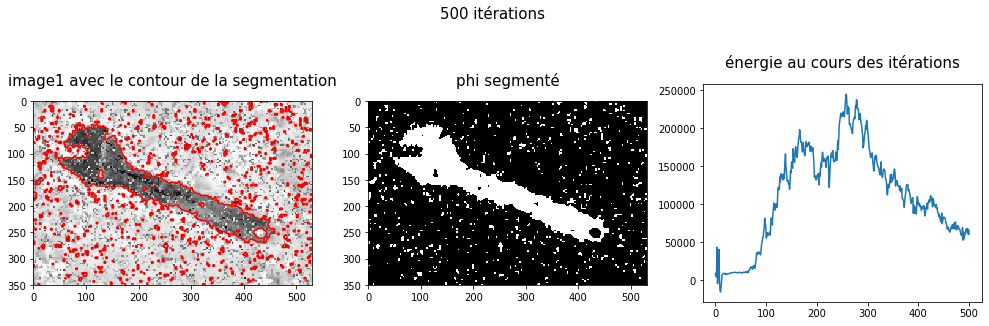

In [59]:
mu = 0.25
lambda1 = 1.0
lambda2 = 1.0
tol = 1e-3
max_it = 500
dt = 0.5
eps = 1.
eta2 = 1e-16

IMAGE1 = chanvese(image1, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)

plt.figure(figsize = (17, 4))
plt.suptitle('image1 en ' + str(IMAGE1[3]) + ' itérations', fontsize = 20, y = 1.15)
plt.subplot(1,3,1)
plt.title('image1 avec le contour de la segmentation', fontsize = 15, y = 1.05)
plt.imshow(image1, cmap = 'gray')
plt.contour(IMAGE1[1], 1, colors = ['None', 'red'])
plt.subplot(1,3,2)
plt.title('phi segmenté', fontsize = 15, y = 1.05)
plt.imshow(IMAGE1[1], cmap = 'gray')
plt.subplot(1,3,3)
plt.title('énergie au cours des itérations', fontsize = 15, y = 1.05)
plt.plot(IMAGE1[2])
plt.show()

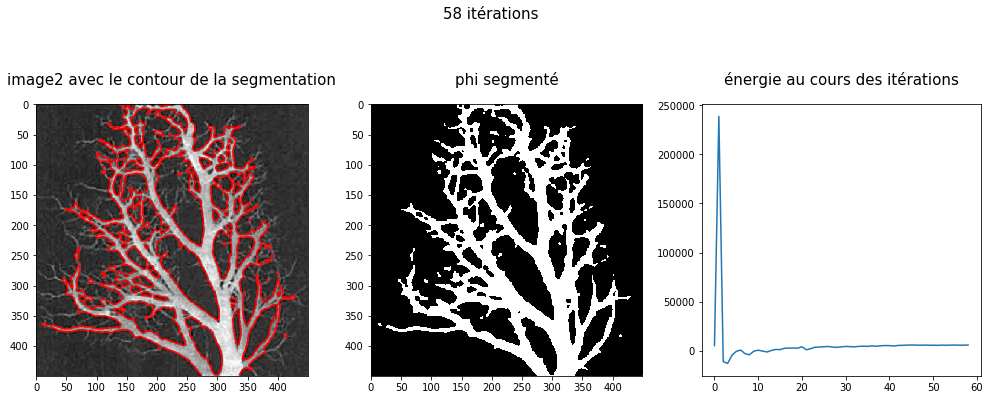

In [60]:
mu = 0.25
lambda1 = 1.0
lambda2 = 1.0
tol = 1e-3
max_it = 500
dt = 0.5
eps = 1.
eta2 = 1e-16

IMAGE2 = chanvese(image2, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)

plt.figure(figsize = (17, 5))
plt.suptitle('image2 en ' + str(IMAGE2[3]) + ' itérations', fontsize = 20, y = 1.15)
plt.subplot(1,3,1)
plt.title('image2 avec le contour de la segmentation', fontsize = 15, y = 1.05)
plt.imshow(image2, cmap = 'gray')
plt.contour(IMAGE2[1], 1, colors = ['None', 'red'])
plt.subplot(1,3,2)
plt.title('phi segmenté', fontsize = 15, y = 1.05)
plt.imshow(IMAGE2[1], cmap = 'gray')
plt.subplot(1,3,3)
plt.title('énergie au cours des itérations', fontsize = 15, y = 1.05)
plt.plot(IMAGE2[2])
plt.show()

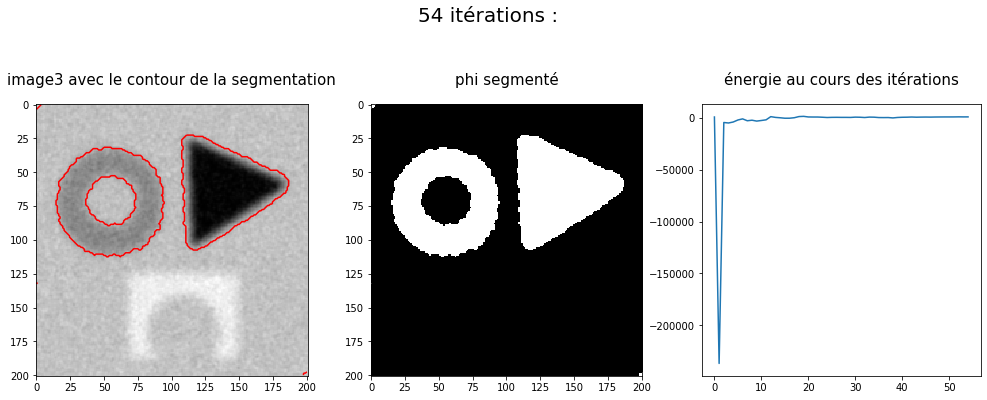

In [63]:
mu = 0.25
lambda1 = 1.0
lambda2 = 1.0
tol = 1e-3
max_it = 500
dt = 0.5
eps = 1.
eta2 = 1e-16

IMAGE3 = chanvese(image3, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)

plt.figure(figsize = (17, 5))
plt.suptitle('image3 en ' + str(IMAGE3[3]) + ' itérations', fontsize = 20, y = 1.15)
plt.subplot(1,3,1)
plt.title('image3 avec le contour de la segmentation', fontsize = 15, y = 1.05)
plt.imshow(image3, cmap = 'gray')
plt.contour(IMAGE3[1], 1, colors = ['None', 'red'])
plt.subplot(1,3,2)
plt.title('phi segmenté', fontsize = 15, y = 1.05)
plt.imshow(IMAGE3[1], cmap = 'gray')
plt.subplot(1,3,3)
plt.title('énergie au cours des itérations', fontsize = 15, y = 1.05)
plt.plot(IMAGE3[2])
plt.show()

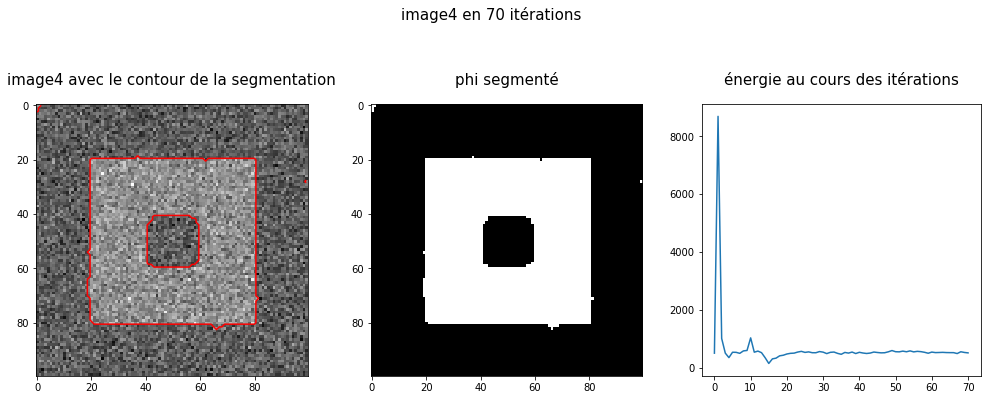

In [64]:
mu = 0.25
lambda1 = 1.0
lambda2 = 1.0
tol = 1e-3
max_it = 500
dt = 0.5
eps = 1.
eta2 = 1e-16

IMAGE4 = chanvese(image4, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)

plt.figure(figsize = (17, 5))
plt.suptitle('image4 en ' + str(IMAGE4[3]) + ' itérations', fontsize = 15, y = 1.15)
plt.subplot(1,3,1)
plt.title('image4 avec le contour de la segmentation', fontsize = 15, y = 1.05)
plt.imshow(image4, cmap = 'gray')
plt.contour(IMAGE4[1], 1, colors = ['None', 'red'])
plt.subplot(1,3,2)
plt.title('phi segmenté', fontsize = 15, y = 1.05)
plt.imshow(IMAGE4[1], cmap = 'gray')
plt.subplot(1,3,3)
plt.title('énergie au cours des itérations', fontsize = 15, y = 1.05)
plt.plot(IMAGE4[2])
plt.show()

Les résultats qu'on obtien avec un nombre d'itération croissant.

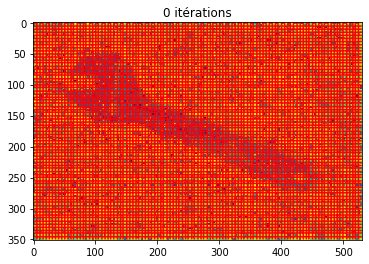

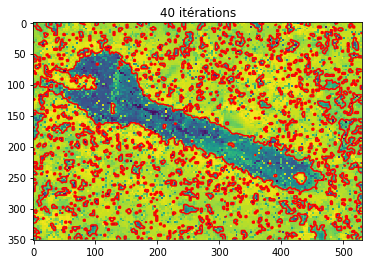

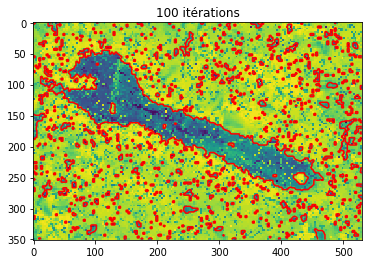

In [68]:
max_it = 0
IMAGE1A = chanvese(image1, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.title(str(max_it) + ' itérations')
plt.imshow(image1)
plt.contour(IMAGE1A[1], 1, colors = ['None', 'red'])
plt.show()

max_it = 40
IMAGE1A = chanvese(image1, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.title(str(max_it) + ' itérations')
plt.imshow(image1)
plt.contour(IMAGE1A[1], 1, colors = ['None', 'red'])
plt.show()

max_it = 100
IMAGE1A = chanvese(image1, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.title(str(max_it) + ' itérations')
plt.imshow(image1)
plt.contour(IMAGE1A[1], 1, colors = ['None', 'red'])
plt.show()

On test avec les fonctions qu'on a défini pour level-set.

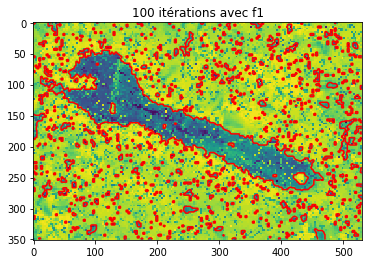

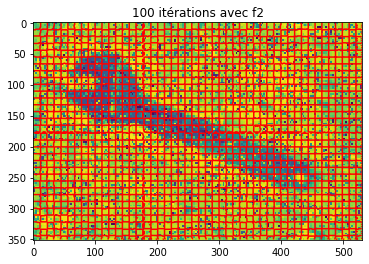

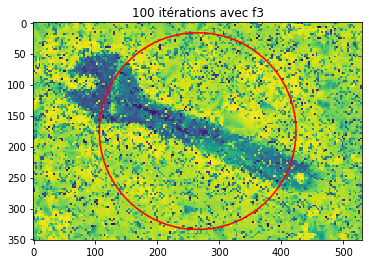

In [71]:
max_it = 100
IMAGE1A = chanvese(image1, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.title(str(max_it) + ' itérations avec f1')
plt.imshow(image1)
plt.contour(IMAGE1A[1], 1, colors = ['None', 'red'])
plt.show()

max_it = 100
IMAGE1A = chanvese(image1, f2, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.title(str(max_it) + ' itérations avec f2')
plt.imshow(image1)
plt.contour(IMAGE1A[1], 1, colors = ['None', 'red'])
plt.show()

max_it = 100
IMAGE1A = chanvese(image1, f3, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.title(str(max_it) + ' itérations avec f3')
plt.imshow(image1)
plt.contour(IMAGE1A[1], 1, colors = ['None', 'red'])
plt.show()

On remarque la premiere fonction converge très rapidement, et les autres doivent prendre énormément de temps.

On va voir ce que l'algorithme fais avec des valeurs différentes pour $\mu$.

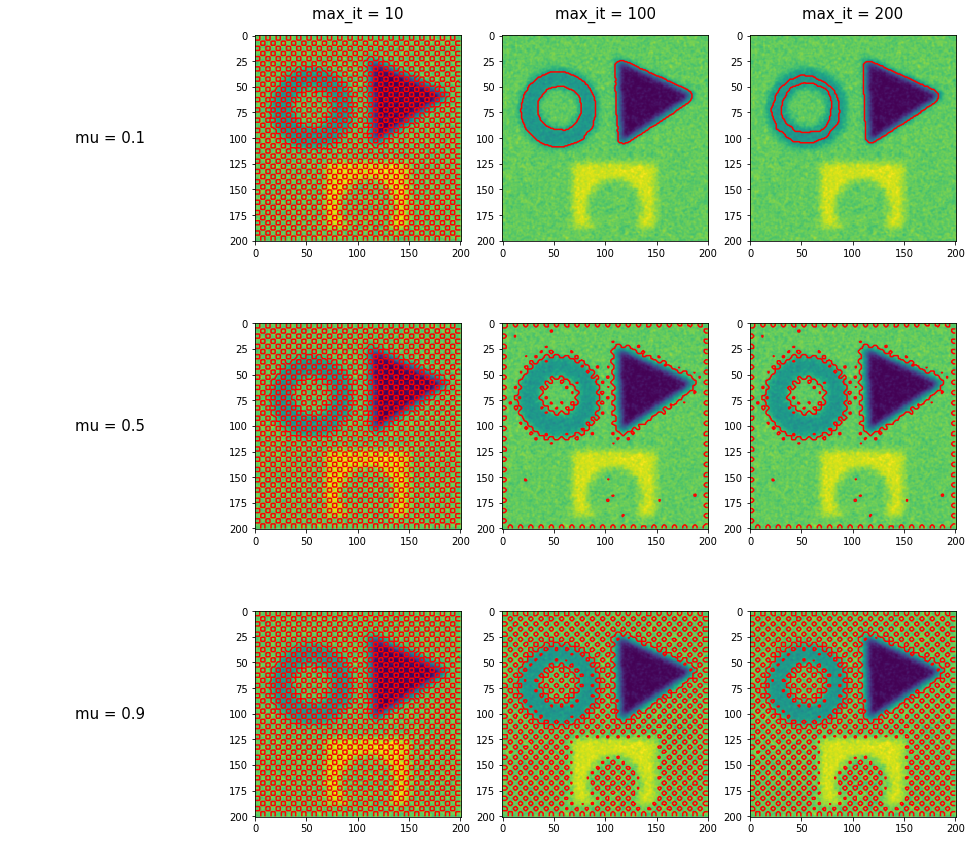

In [92]:
lambda1 = 1.0
lambda2 = 1.0
tol = 1e-3
dt = 0.5
eps = 1.
eta2 = 1e-16

max_it1 = 10
max_it2 = 100
max_it3 = 200

mu1 = 0.1
mu2 = 0.5
mu3 = 0.9

plt.figure(figsize = (17, 15))

plt.subplot(3, 4, 1)
plt.text(0.5, 0.5, 'mu = ' + str(mu1), horizontalalignment = 'center', verticalalignment = 'center', fontsize = 15)
plt.axis('off')

plt.subplot(3, 4, 2)
mu = mu1
max_it = max_it1
IMAGE3 = chanvese(image3, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.title('max_it = ' + str(max_it1), fontsize = 15, y = 1.05)
plt.imshow(image3)
plt.contour(IMAGE3[1], 1, colors = ['None', 'red'])

plt.subplot(3, 4, 3)
max_it = max_it2
IMAGE3 = chanvese(image3, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.title('max_it = ' + str(max_it2), fontsize = 15, y = 1.05)
plt.imshow(image3)
plt.contour(IMAGE3[1], 1, colors = ['None', 'red'])

plt.subplot(3, 4, 4)
max_it = max_it3
IMAGE3 = chanvese(image3, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.title('max_it = ' + str(max_it3), fontsize = 15, y = 1.05)
plt.imshow(image3)
plt.contour(IMAGE3[1], 1, colors = ['None', 'red'])

plt.subplot(3, 4, 5)
plt.text(0.5, 0.5, 'mu = ' + str(mu2), horizontalalignment = 'center', verticalalignment = 'center', fontsize = 15)
plt.axis('off')

plt.subplot(3, 4, 6)
mu = mu2
max_it = max_it1
IMAGE3 = chanvese(image3, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.imshow(image3)
plt.contour(IMAGE3[1], 1, colors = ['None', 'red'])

plt.subplot(3, 4, 7)
max_it = max_it2
IMAGE3 = chanvese(image3, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.imshow(image3)
plt.contour(IMAGE3[1], 1, colors = ['None', 'red'])

plt.subplot(3, 4, 8)
max_it = max_it3
IMAGE3 = chanvese(image3, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.imshow(image3)
plt.contour(IMAGE3[1], 1, colors = ['None', 'red'])

plt.subplot(3, 4, 9)
plt.text(0.5, 0.5, 'mu = ' + str(mu3), horizontalalignment = 'center', verticalalignment = 'center', fontsize = 15)
plt.axis('off')

plt.subplot(3, 4, 10)
mu = mu3
max_it = max_it1
IMAGE3 = chanvese(image3, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.imshow(image3)
plt.contour(IMAGE3[1], 1, colors = ['None', 'red'])

plt.subplot(3, 4, 11)
max_it = max_it2
IMAGE3 = chanvese(image3, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.imshow(image3)
plt.contour(IMAGE3[1], 1, colors = ['None', 'red'])

plt.subplot(3, 4, 12)
max_it = max_it3
IMAGE3 = chanvese(image3, f1, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)
plt.imshow(image3)
plt.contour(IMAGE3[1], 1, colors = ['None', 'red'])

plt.show()

# Animation

In [73]:
def chanvese_anim(image, f, vit, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2):

    sx, sy = image.shape

    # Initialisation du level set
    phi = level_set(sx, sy, f)

    segmentation = phi > 0  # on peut mettre np.int_ pour des 1 et 0

    convergence = tol + 1
    it = 0  # itération
    plt.figure(figsize = (20, 10))
    plt.title(str(it))
    plt.imshow(image, cmap = 'gray')
    plt.contour(segmentation, 1, colors = ['None', 'red'])
    plt.show()

    while (it < max_it and convergence > tol):
        phi_tmp = phi

        P = double_bord(phi, sx, sy)
        phixp = P[1:-1, 2:] - P[1:-1, 1:-1]
        phixn = P[1:-1, 1:-1] - P[1:-1, :-2]
        phix0 = (P[1:-1, 2:] - P[1:-1, :-2]) / 2.
        phiyp = P[2:, 1:-1] - P[1:-1, 1:-1]
        phiyn = P[1:-1, 1:-1] - P[:-2, 1:-1]
        phiy0 = (P[2:, 1:-1] - P[:-2, 1:-1]) / 2.
        C1 = 1. / np.sqrt(eta2 + phixp ** 2 + phiy0 ** 2)
        C2 = 1. / np.sqrt(eta2 + phixn ** 2 + phiy0 ** 2)
        C3 = 1. / np.sqrt(eta2 + phix0 ** 2 + phiyp ** 2)
        C4 = 1. / np.sqrt(eta2 + phix0 ** 2 + phiyn ** 2)
        K = (P[1:-1, 2:] * C1 + P[1:-1, :-2] * C2 + P[2:, 1:-1] * C3 + P[:-2, 1:-1] * C4)
        H1 = phi > 0
        H2 = 1. - H1
        c1, c2 = calcul_c1_c2(image, H1, H2, eps)
        new_phi = (phi + (dt * delta(phi, eps)) * (mu * K + (- lambda1 * (image - c1) ** 2 + lambda2 * (image - c2) ** 2)))
        phi = new_phi / (1 + mu * dt * delta(phi, eps) * (C1 + C2 + C3 + C4))

        convergence = np.sqrt(((phi - phi_tmp) ** 2).mean())

        segmentation = phi > 0

        it += 1
        clear_output(wait = True)
        plt.figure(figsize = (20, 10))
        plt.title(str(it))
        plt.imshow(image, cmap = 'gray')
        plt.contour(segmentation, 1, colors = ['None', 'red'])
        plt.show()
        time.sleep(vit)
    return

In [76]:
mu = 0.25
lambda1 = 1.0
lambda2 = 1.0
tol = 1e-3
max_it = 500
dt = 0.5
eps = 1.
eta2 = 1e-16

vit = 0.1  #vitesse de l'animation (pause entre les 2 itérations)

chanvese_anim(image1, f1, vit, mu, lambda1, lambda2, tol, max_it, dt, eps, eta2)

KeyboardInterrupt: 